In [1]:
import os
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import kagglehub

path = kagglehub.dataset_download("hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages")

print("Path to dataset files:", path)

100%|██████████| 17.9G/17.9G [07:56<00:00, 40.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1


In [4]:
for root, dirs, files in os.walk(path):
    print("Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files[:5])
    print("-" * 50)


Directory: /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1
Subdirectories: ['Language Detection Dataset']
Files: []
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset
Subdirectories: ['Malayalam', 'Marathi', 'Telugu', 'Urdu', 'Bengali', 'Kannada', 'Hindi', 'Tamil', 'Gujarati', 'Punjabi']
Files: []
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Malayalam
Subdirectories: []
Files: ['3893.mp3', '8707.mp3', '12693.mp3', '16924.mp3', '4448.mp3']
--------------------------------------------------
Directory: /root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Marathi
Subdirectories

In [5]:
languages=['Marathi', 'Gujarati', 'Urdu', 'Malayalam', 'Punjabi', 'Kannada', 'Bengali', 'Hindi', 'Tamil', 'Telugu']

In [6]:
def extract_full_mfcc(file_path, n_mfcc=13):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc)
    mfcc = mfcc_transform(waveform)
    return mfcc.squeeze(0)

In [7]:
n_samples = 3
sample_files = {}
DATASET_PATH = "/root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset"
for lang in ["Hindi", "Bengali", "Tamil"]:
    lang_path = os.path.join(DATASET_PATH, lang)
    files = [os.path.join(lang_path, f) for f in os.listdir(lang_path) if f.endswith(".mp3")]
    sample_files[lang] = files[:n_samples]

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


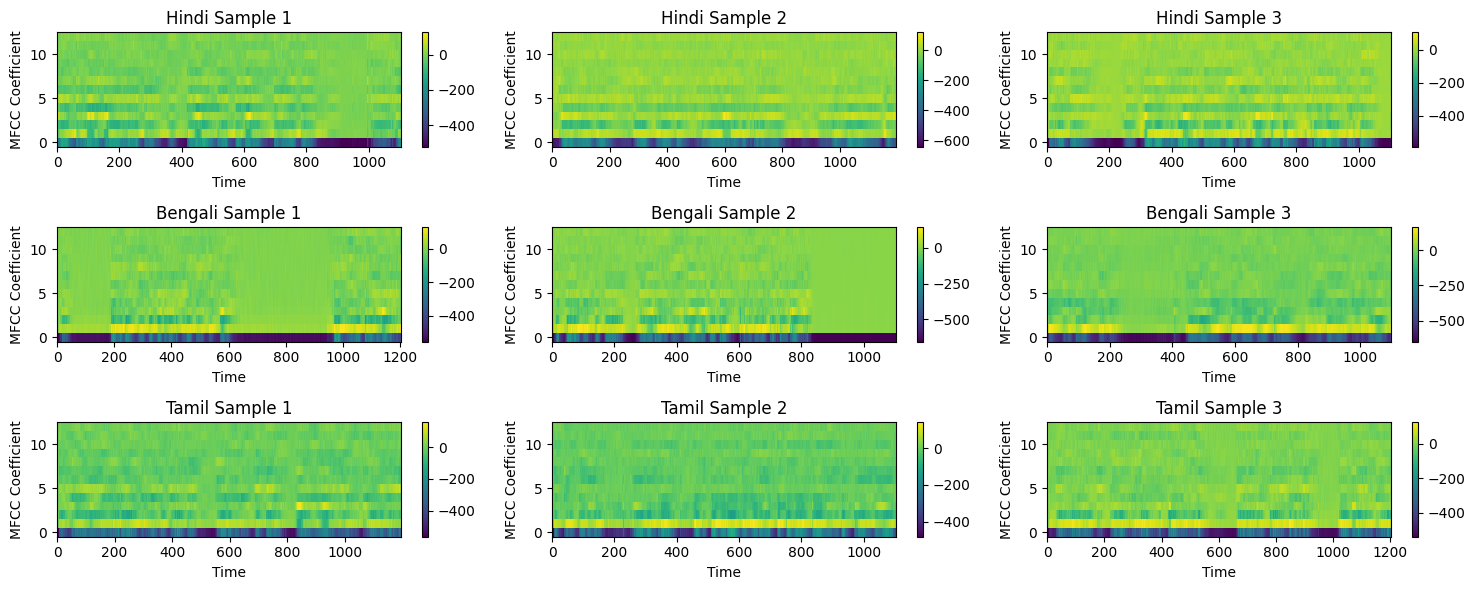

In [8]:
fig, axes = plt.subplots(len(sample_files), n_samples, figsize=(15, 6))
for i, (lang, files) in enumerate(sample_files.items()):
    for j, file in enumerate(files):
        mfcc = extract_full_mfcc(file)
        ax = axes[i, j] if len(sample_files) > 1 else axes[j]
        im = ax.imshow(mfcc.numpy(), aspect='auto', origin='lower', interpolation='none')
        ax.set_title(f"{lang} Sample {j+1}")
        ax.set_xlabel("Time")
        ax.set_ylabel("MFCC Coefficient")
        fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [9]:
statistics = {}
for lang, files in sample_files.items():
    mfcc_means = []
    mfcc_vars = []
    for file in files:
        mfcc = extract_full_mfcc(file)
        mfcc_means.append(mfcc.numpy().mean(axis=1))
        mfcc_vars.append(mfcc.numpy().var(axis=1))
    statistics[lang] = {
        "Mean": np.mean(mfcc_means, axis=0),
        "Variance": np.mean(mfcc_vars, axis=0)
    }

In [10]:
for lang, stats in statistics.items():
    print(f"\nStatistics for {lang}:")
    print("Mean:", stats["Mean"])
    print("Variance:", stats["Variance"])


Statistics for Hindi:
Mean: [-356.6464      22.437286   -53.648724    15.27145    -46.179626
   15.9709635  -26.151098     1.0975405  -12.711494    -7.5736747
   -0.8048323   -6.4715295    1.9941908]
Variance: [13439.519     1189.4004    1778.0016     774.70514    719.6057
   352.63535    351.15683    294.7929     232.57104    109.62118
   139.53088    104.570564    97.709015]

Statistics for Bengali:
Mean: [-461.90964     59.69203    -36.82519     -6.290113   -23.649641
    1.5237244  -10.453971    -9.227844    -3.9508622   -7.6679153
   -6.262034    -5.305679    -1.0940317]
Variance: [13219.81     1898.084    2607.162     916.3803    643.6219    300.28592
   272.85522   326.8495    187.28893   123.62745   112.61334   102.26061
    97.25382]

Statistics for Tamil:
Mean: [-3.2266312e+02  6.6638771e+01 -4.7601105e+01  2.4466260e-01
 -2.6432268e+01  9.6239252e+00 -2.1349136e+01 -2.1037323e+01
 -8.3104811e+00 -6.7657280e+00 -6.5383811e+00 -7.4799733e+00
  4.1491881e-01]
Variance: [7832.1

In [11]:
def extract_mean_mfcc(file_path, n_mfcc=13):
    waveform, sample_rate = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc)
    mfcc = mfcc_transform(waveform)
    return mfcc.squeeze(0).numpy().mean(axis=1)

In [12]:
X, y_labels = [], []
for lang in languages:
    lang_path = os.path.join(DATASET_PATH, lang)
    for file in os.listdir(lang_path):
        if file.endswith(".mp3"):
            file_path = os.path.join(lang_path, file)
            try:
                features = extract_mean_mfcc(file_path)
                X.append(features)
                y_labels.append(lang)
            except Exception as e:
                print(f"Error processing {file} in {lang}: {e}")

Error processing 13430.mp3 in Gujarati: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (200, 200) at dimension 2 of input [1, 1, 14]
Error processing 5339.mp3 in Urdu: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (200, 200) at dimension 2 of input [1, 1, 126]
Error processing 14280.mp3 in Punjabi: Argument #4: Padding size should be less than the corresponding input dimension, but got: padding (200, 200) at dimension 2 of input [1, 1, 14]
Error processing 26936.mp3 in Bengali: Failed to open the input "/root/.cache/kagglehub/datasets/hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages/versions/1/Language Detection Dataset/Bengali/26936.mp3" (Invalid argument).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::str

In [13]:
if len(X) == 0:
    raise ValueError("No features extracted. Check file paths and file format.")

X = np.array(X)
print("Extracted features shape:", X.shape)

Extracted features shape: (256827, 13)


In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)

Training set shape: (205461, 13)


In [15]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [16]:
class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.log_softmax(x)

In [17]:
input_size = X_train.shape[1]
num_classes = len(languages)
model = AudioClassifier(input_size, num_classes).to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
num_epochs = 20
batch_size = 32

print("\nStarting Training...")
for epoch in range(num_epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))

    epoch_loss = 0.0
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_train_tensor[indices]
        batch_y = y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/((X_train_tensor.size(0)//batch_size)+1):.4f}")



Starting Training...
Epoch [1/20], Loss: 0.5221
Epoch [2/20], Loss: 0.3218
Epoch [3/20], Loss: 0.2850
Epoch [4/20], Loss: 0.2669
Epoch [5/20], Loss: 0.2551
Epoch [6/20], Loss: 0.2469
Epoch [7/20], Loss: 0.2408
Epoch [8/20], Loss: 0.2362
Epoch [9/20], Loss: 0.2325
Epoch [10/20], Loss: 0.2296
Epoch [11/20], Loss: 0.2270
Epoch [12/20], Loss: 0.2247
Epoch [13/20], Loss: 0.2224
Epoch [14/20], Loss: 0.2209
Epoch [15/20], Loss: 0.2198
Epoch [16/20], Loss: 0.2177
Epoch [17/20], Loss: 0.2161
Epoch [18/20], Loss: 0.2155
Epoch [19/20], Loss: 0.2145
Epoch [20/20], Loss: 0.2133


In [20]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8768


In [21]:
y_true = y_test_tensor.cpu().numpy()
y_pred = predicted.cpu().numpy()
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Bengali       0.96      0.97      0.97      5522
    Gujarati       0.49      0.98      0.66      5313
       Hindi       0.97      1.00      0.98      5076
     Kannada       0.98      0.96      0.97      4395
   Malayalam       0.98      0.97      0.98      4766
     Marathi       0.98      0.98      0.98      4961
     Punjabi       0.32      0.00      0.00      5274
       Tamil       0.98      0.98      0.98      4961
      Telugu       0.99      0.97      0.98      4747
        Urdu       0.97      0.97      0.97      6351

    accuracy                           0.88     51366
   macro avg       0.86      0.88      0.85     51366
weighted avg       0.86      0.88      0.84     51366



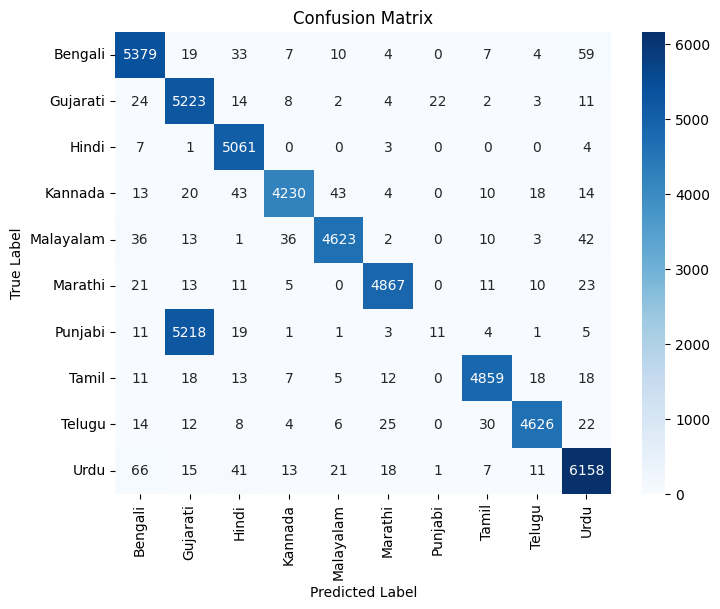

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()